In [239]:
import mdtraj as md
import matplotlib.pyplot  as plt
import pyemma
import seaborn as sns
import numpy as np
%matplotlib inline

https://en.wikipedia.org/wiki/Grand_Tour_(data_visualisation)

In [391]:
def alpha(k, N, fac):
    """
    a curve in the N torus
    N = 2*p-3
    """    
    primes = np.array([2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 
                       41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 
                       89, 97, 101, 103, 107, 109, 113, 127, 131, 
                       137, 139, 149, 151, 157, 163, 167, 173, 179, 
                       181, 191, 193, 197, 199, 211, 223, 227, 229, 
                       233, 239, 241, 251, 257, 263, 269, 271, 277,
                       281, 283, 293, 307, 311, 313, 317, 331, 337, 
                       347, 349, 353, 359, 367, 373, 379, 383, 389, 397])

    assert N <= len(primes), 'not implemented this many dimensions'
    lambdas = np.sqrt(primes[:N])
    step = np.sqrt(2)/fac
    angles = lambdas*step*k % 2*np.pi
    return angles

def differences(angles, p):
    """
    The angles are a curve through toroidal space. 
    This returns the differences in the defined in the appendix. 
    
    """
    diffs = []
    ix = []
    for i in range(2):
        for j in range(i+1, p):
            diffs.append(angles[j]-angles[i]) 
            ix.append([i, j])
            
    diffs = np.array(diffs)
    diffs = diffs % 2*np.pi
    return diffs, ix

def Rij(theta, i,j, p=3):
    rot = np.array([[np.cos(theta), -np.sin(theta)], 
                    [np.sin(theta), np.cos(theta)]])
    R = np.eye(p)
    R[np.ix_([i, j], [i, j])] = rot
    return R
    

def rotations(k, p=3, fac=100):
    """
    All the rotations on the unit p-sphere combined. 
    Rotations are defined by differences of the torus angles
    """
    N = int(2*p-3)
    R = np.eye(p)
    angles = alpha(k, N, fac=fac)

    diffs, ix = differences(angles, p)
    
    for i in range(diffs.shape[0]):
        R = Rij(diffs[i], ix[i][0],ix[i][1], p=p) @ R
    
    assert np.allclose(R @ R.T, np.eye(p)), "Rotation matrix isn't orthogonal"
    return R
    
    

In [360]:
# x, y, z = np.meshgrid(np.linspace(-1, 1, 10), np.linspace(-1, 1, 10), np.linspace(-1, 1, 10))
# X = np.concatenate([x.flatten()[:, None], 
#                     y.flatten()[:, None], 
#                     z.flatten()[:, None]], axis=1)


# cols = 1*(np.abs(X[:, 0])==1) + 2*(np.abs(X[:, 1])==1) + 3*(np.abs(X[:, 2])==1)

# cols = X[:, 0] + X[:, 1]
# cols[np.abs(np.sum(X, axis=1))==2] = 5

# fig, axes = plt.subplots(5, 5, figsize=(10, 10))

# for i, ax in enumerate(axes.flatten()):
    
# # ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c =cols)
# # ax1.set_ylim((-1, 1))
# # ax1.set_xlim((-1, 1))
# # ax1.set_zlim((-1, 1))
#     R = rotations(k=i, p=X.shape[1])
#     Xnew = X @ R
#     ax.scatter(Xnew[:, 0], Xnew[:, 1], c =cols)
#     ax.set_xlim(-2, 2)
#     ax.set_ylim(-2, 2)

# plt.tight_layout()


# from matplotlib.animation import FuncAnimation, PillowWriter

# fig, ax = plt.subplots()
# ln = ax.scatter([], [])

# def init():
#     ax.set_xlim(-2, 2)
#     ax.set_ylim(-2, 2)
#     return ln,

# def update(frame):
#     R = rotations(k=frame, p=X.shape[1])
#     Xnew = X @ R
#     ln.set_offsets(Xnew[:, :2])
#     ln.set_array(cols)
#     return ln,

# ani = FuncAnimation(fig, update, frames=np.arange(100),
#                     init_func=init, blit=True)
# writergif = PillowWriter(fps=10) 

# ani.save('cube.gif', writer=writergif)

In [361]:
trajs = [np.load('data/features/positions/{:03d}.npy'.format(i)) for i in range(750)]

tica = pyemma.coordinates.tica(trajs, tau=1, dim=10)

Y = tica.get_output()

Y_all = np.concatenate(Y, axis=0)

cluster = pyemma.coordinates.cluster_kmeans(Y_all, k=100, stride=10, max_iter=100)

dtrajs = cluster.dtrajs
mm = pyemma.msm.estimate_markov_model(dtrajs, lag=1)

cols = mm.pi[dtrajs]

100%|██████████| 100/100 [00:01<00:00, 92.35it/s]                             

100%|██████████| 100/100 [00:11<00:00,  8.34it/s]
/Users/robertarbon/opt/miniconda3/envs/pyemma/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


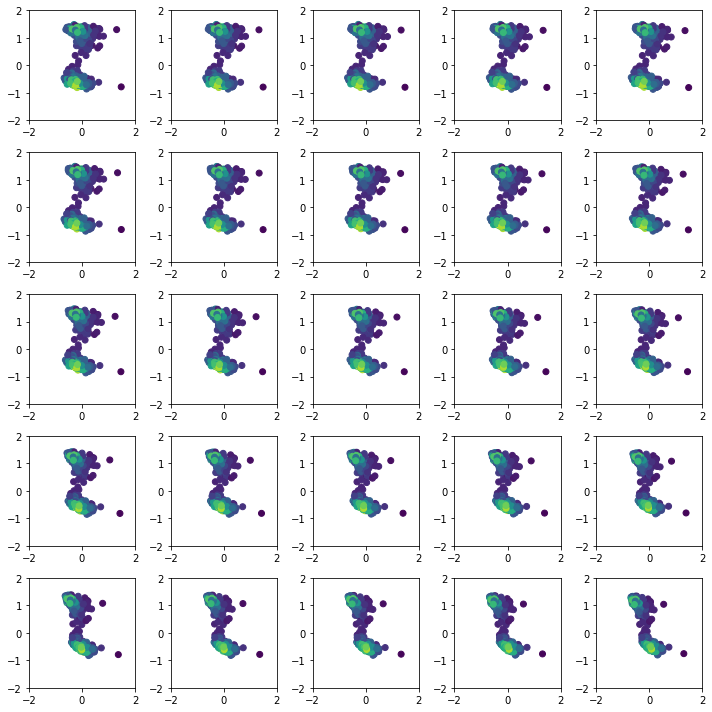

In [387]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

Xnew = Y_all[:, :4]
for i, ax in enumerate(axes.flatten()):

    R = rotations(k=i, p=Xnew.shape[1], fac=500)
    stride = 1000
    X = Xnew @ R
    ax.scatter(X[::stride, 0], X[::stride, 1], c =cols[::stride])
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)

plt.tight_layout()

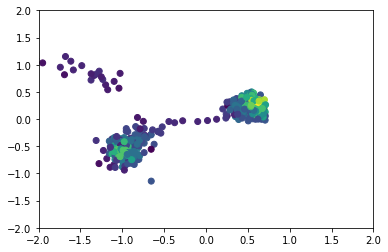

In [390]:
fig, ax = plt.subplots()
ln = ax.scatter([], [])

p = 4

def init():
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    return ln,

def update(frame):
    R = rotations(k=frame, p=p, fac=1000)
    stride = 1000
    Xnew = Y_all[::stride, :p] @ R
    ln.set_offsets(Xnew[:, :2])
    ln.set_array(cols[::stride])
    return ln,

ani = FuncAnimation(fig, update, frames=np.arange(1000),
                    init_func=init, blit=True)
writergif = PillowWriter(fps=30) 

ani.save('alanine.gif', writer=writergif)
